# CoCliCo --- Delft Notebook Demonstration (October 2023)

Coastal Climate Core Services (CoCliCo) is an European effort to develop an opean web-platform to aid decision making on coastal risk (2021 - 2025). Please have a look at our [website](https://coclicoservices.eu/) to find out more about the project. 

During this project several datasets will be made available, which can be explored on the platform as well as accessed via cloud-storage buckets. In this notebook, some examples are provided on how to interact with the data using Python, specifically for sea level rise projections from the Intergovernmental Panel on Climate Change (IPCC) at national scales.

- Notebook author: Etiënne Kras, 26 July 2023

### Software environment

- Please install the latest mambaforge package manager by downloading the executable from the [MiniForge GitHub repo](https://github.com/conda-forge/miniforge#mambaforge) for your Operating System. 
- Clone the [coclicodata GitHub repo](https://github.com/openearth/coclicodata) on your local desktop using Git or GitHub Desktop.
- Open a Miniforge Prompt (terminal) on your local desktop. 
- Navigate to the coclicodata GitHub repo in the Miniforge Prompt and run `mamba env create -f environment.yml`. 
- This may take a few minutes to complete but once it is finished you will have all required packages to run this notebook installed in your ‘coclico’ environment. 

## IPCC AR5 & AR6 sea level rise projections 

Here, we use [IPCC's](https://www.ipcc.ch/) Fifth Assessment Report (AR5, 2013) relative Sea Surface Height (SSH) data processed by the [Integrated Climate Data Center (ICDC, CEN, University of Hamburg)](https://www.cen.uni-hamburg.de/en/icdc/data/ocean/ar5-slr.html). The data includes 10 geophysical sources that drive long-term changes in relative sea level change; 5 ice components, 3 ocean-related components, a land water storage and glacial isostatic adjustment. Also, we consider IPCC's latest medium confidence relative median regional sea level projections published in the Sixth Assessment Report (AR6, 2021) processed by [NASA's Jet Propulsion Laboratory](https://podaac.jpl.nasa.gov/announcements/2021-08-09-Sea-level-projections-from-the-IPCC-6th-Assessment-Report). The data includes antarctic ice sheet, greenland ice sheet, glaciers, land-water storage, ocean dynamics and vertical land motion as geophysical sources that drive long-term changes. 

The data is hosted in cloud buckets as Cloud Optimized GeoTIFFs (COGs). [COG](https://www.cogeo.org/) is a regular GeoTIFF file (viewed in for instance QGIS) but aimed at being hosted on a HTTP file server, with an internal organization that enables more efficient workflows in the cloud. You can basically ask for parts of the file you need which make post-processing routines very fast.



### Imports

In [1]:
import warnings
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
import pystac_client
#import xarray as xr
import rioxarray as rio
#import holoviews as hv
import cartopy.crs as ccrs
import cartopy.feature as cf
from tqdm import tqdm
import pandas as pd
import numpy as np

# ignore warnings
warnings.filterwarnings("ignore")

### CoCliCo STAC catalog

In [2]:
# load the CoCliCo STAC catalog
catalog = pystac_client.Client.open(
    "https://storage.googleapis.com/dgds-data-public/coclico/coclico-stac/catalog.json"
)
#catalog

# list the datasets present in the catalog, we are interested in the slp5 and slp6 sets
list(catalog.get_children())

[<CollectionClient id=ssl>,
 <CollectionClient id=wef>,
 <CollectionClient id=eesl>,
 <CollectionClient id=floodmaps>,
 <CollectionClient id=sc>,
 <CollectionClient id=cbca>,
 <CollectionClient id=cfr>,
 <CollectionClient id=cm>,
 <CollectionClient id=smd>,
 <CollectionClient id=cisi>,
 <CollectionClient id=slp5>,
 <CollectionClient id=slp6>]

### Define parameter space

In [3]:
yr = 2100 # set year
ens = 50 # set ensemble [0-100]
var = "slr" # set variable
ccs5 = "26" # set climate change scenario for AR5 
ccs6 = "1-26" # set climate change scenario for AR5 

# CONTINUE
# open href items with rio xarray to display them (first as normal plot then with holoviews?)
# use parameter space to change the opened item for the plot
# use the catalog content to make the plot nice (i.e. same bounding boxes, etc)
# import land-water line (rough) to display land?

# look at py-sense to have some examples
# do we need a zarr file to easily query temporal information or can we do that by loading all cog information easily?
# if so, then we would need an algorithm that resets the clicked point to the closest cell center to query from the zarr

# can we do this all in an html or something that people can just slide without running the code??

### Geospatial plot

In [4]:
# get data
# TODO: how to speed this up for datapoints at the end to the ar5/6_col?

# get AR5 collection and item href
ar5_col = catalog.get_child("slp5")
ar5_item_href = ar5_col.get_item(r"rcp=%s/%s_ens%s/%s-01-01_%s-01-01.tif"%(ccs5, var, int(ens), yr, yr+1)).assets["data"].href
ar5_item = rio.open_rasterio(ar5_item_href, masked=True)

# get AR6 collection and item href
ar6_col = catalog.get_child("slp6")
ar6_item_href = ar6_col.get_item(r"ssp=%s/%s_ens%s/%s.tif"%(ccs6, var, float(ens), yr)).assets["data"].href
ar6_item = rio.open_rasterio(ar6_item_href, masked=True)
ar6_item_corr= ar6_item/1000

# cbar limits
vmin = max(min(np.nanmin(ar5_item), np.nanmin(ar6_item_corr)), -0.2) # bound to -0.2 if smaller than this value
vmax = max(np.nanmax(ar5_item), np.nanmax(ar6_item_corr)) 

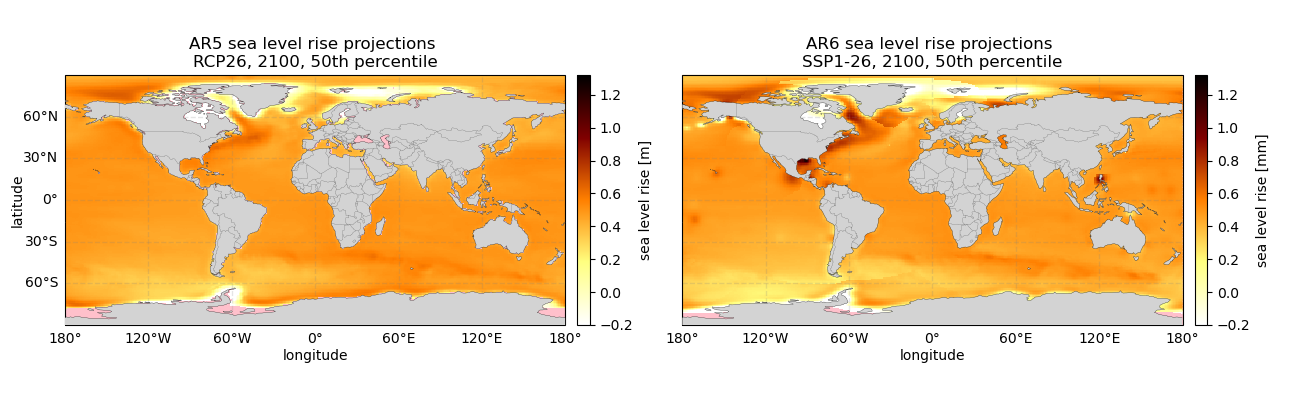

In [5]:
%matplotlib ipympl
#%matplotlib inline

# TODO: zoom with ipyleaflet bbox converted to this plot?
# TODO: zoom to same extent (sharex, sharey does not work properly) when selecting a boundings box in ipympl

# define figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13,4), subplot_kw={'projection': ccrs.PlateCarree()}) #, sharex=True, sharey=True)
fig.tight_layout()
#plt.gcf().subplots_adjust(bottom=0.05)
plt.gcf().subplots_adjust(left=0.05)

# populate AR5 plot
ax1.set_facecolor('pink')
im5 = ar5_item.plot(ax=ax1, add_colorbar=False, vmin=round(vmin,2), vmax=round(vmax,2), cmap=plt.cm.afmhot_r)
ax1.set_title("%s \nRCP%s, %s, %sth percentile"%(ar5_col.title, ccs5, yr, ens))
#ax1.set_xlabel("Longitude [Degrees East]") # TODO: possibly import from file?
#ax1.set_ylabel("Latitude [Degrees North]") # TODO: possibly import from file?
cbar5 = plt.colorbar(im5, shrink=0.675, aspect=30*0.675, pad=0.02)
cbar5.set_label('sea level rise [%s]'%ar5_col.extra_fields["deltares:units"]) # TODO: possibly import from file?
ax1.add_feature(cf.LAND, facecolor='lightgrey', zorder=15)
ax1.add_feature(cf.COASTLINE, linewidth=0.2, zorder=16)
ax1.add_feature(cf.BORDERS, linewidth=0.1, zorder=16)
gl1 = ax1.gridlines(crs = ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.2, linestyle='--')
gl1.xlabels_top = False
gl1.ylabels_right = False
ax1.text(-0.08, 0.5, 'latitude', va='bottom', ha='center', rotation='vertical', rotation_mode='anchor', transform=ax1.transAxes)
ax1.text(0.5, -0.15, 'longitude', va='bottom', ha='center', rotation='horizontal', rotation_mode='anchor', transform=ax1.transAxes)

# populate AR6 plot
ax2.set_facecolor('pink')
im6 = ar6_item_corr.plot(ax=ax2, add_colorbar=False, vmin=round(vmin,2), vmax=round(vmax,2), cmap=plt.cm.afmhot_r)
ax2.set_title("%s \nSSP%s, %s, %sth percentile"%(ar6_col.title, ccs6, yr, ens))
#ax2.set_xlabel("Longitude [Degrees East]") # TODO: possibly import from file?
#ax2.set_ylabel("") # leave empty
cbar6 = plt.colorbar(im6, shrink=0.675, aspect=30*0.675, pad=0.02)
cbar6.set_label('sea level rise [%s]'%ar6_col.extra_fields["deltares:units"]) # TODO: possibly import from file?
ax2.add_feature(cf.LAND, facecolor='lightgrey', zorder=15)
ax2.add_feature(cf.COASTLINE, linewidth=0.2, zorder=16)
ax2.add_feature(cf.BORDERS, linewidth=0.1, zorder=16)
gl2 = ax2.gridlines(crs = ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.2, linestyle='--')
gl2.xlabels_top = False
gl2.ylabels_right = False
gl2.ylabels_left = False
ax2.text(0.5, -0.15, 'longitude', va='bottom', ha='center', rotation='horizontal', rotation_mode='anchor', transform=ax2.transAxes);

### Temporal plot

In [6]:
# select a point to plot timeseries of SLR projections for
loc = [4.2, 52.8] # easting, norting

# TODO: enable computing the mean of multiple cells in a polygon or specified set of points and show the SLR projection timeseries

In [8]:
# retrieve AR5 and AR6 data at above-defined location
# TODO: check if Zarr usage is easier here, takes quite some time to index a position from CoG files (https://github.com/intake/intake-stac/issues/66)..
# TODO: what takes more time? get_items or reading the point in the tiff image? If the former, might work to use get_item_links and add string storage location manually 

# define variables
ens_list = ["5", "50", "95"] # ensemble list to look into
yrs_list = np.arange(1970, 2200, 10) # years to look into (step of 10 years from 1970)

# loop over tifs to obtain data for AR5 
key_list = ["CCS", "YRS", "ENS", "SLR"]
AR5_dict = {key: [] for key in key_list}
for idx, (i, j) in tqdm(enumerate(zip(ar5_col.get_items(), ar5_col.get_item_links()))): 
    enss = str(j).split("/")[1].split("ens")[-1] # ensemble
    yrs = int(str(j).split("/")[2][0:4]) # yrs
    if enss in ens_list and yrs in yrs_list: # constraining read ensembles and years
        #print(i.assets["data"].href)
        AR5_dict["CCS"].append(str(i).split("/")[0].split("=")[-1]) # climate change scenario for AR5
        AR5_dict["YRS"].append(yrs) # year, at start of year similar to AR6
        AR5_dict["ENS"].append(enss) # append ensemble
        ar5_item = rio.open_rasterio(i.assets["data"].href, masked=True) # open item
        AR5_dict["SLR"].append(ar5_item.sel(x=loc[0], y=loc[1], method="nearest").values[0]) # match coordinate at center of raster cells

# append to dataframe
df5 = pd.DataFrame(data=AR5_dict)

# loop over tifs to obtain data for AR6 
AR6_dict = {key: [] for key in key_list}
for idx, (i, j) in tqdm(enumerate(zip(ar6_col.get_items(), ar6_col.get_item_links()))): 
    enss = str(j).split("/")[1].split("ens")[-1] # ensemble
    yrs = int(str(j).split("/")[2][0:4]) # yrs
    if enss in [str(float(x)) for x in ens_list] and yrs in yrs_list: # constraining read ensembles and years
        #print(i.assets["data"].href)
        AR6_dict["CCS"].append(str(i).split("/")[0].split("=")[-1]) # climate change scenario for AR5
        AR6_dict["YRS"].append(yrs) # year, at start of year similar to AR6
        AR6_dict["ENS"].append(enss) # append ensemble
        ar6_item = rio.open_rasterio(i.assets["data"].href, masked=True) # open item
        AR6_dict["SLR"].append(ar6_item.sel(x=loc[0], y=loc[1], method="nearest").values[0]/1000) # match coordinate at center of raster cells

# append to dataframe
df6 = pd.DataFrame(data=AR6_dict)

846it [00:56, 15.09it/s] 
4494it [04:02, 18.49it/s]


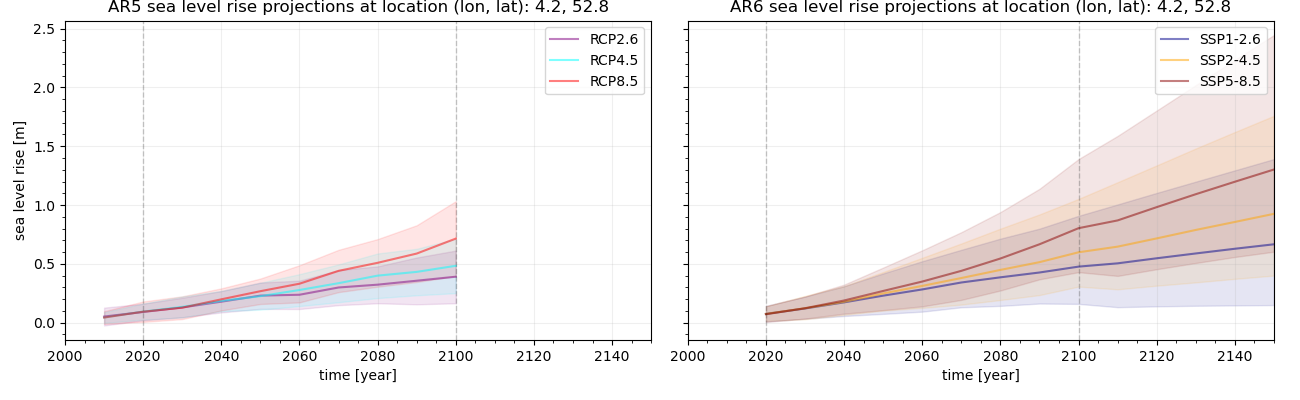

In [15]:
%matplotlib ipympl
#%matplotlib inline

# define figure 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13,4), sharey=True, sharex=True)
fig.tight_layout()
plt.gcf().subplots_adjust(bottom=0.15)
plt.gcf().subplots_adjust(left=0.05)
ax=plt.gca()

# specify colors for plots, different for AR5 & AR6 following official IPCC figures
colorsAR5 = ["purple", "cyan", "red"]
colorsAR6 = ["darkblue","orange","darkred"]

# AR5
for idx, (scen, grp) in enumerate(df5.groupby(["CCS"])): # group per scenario
    ens_list = list(grp.groupby("ENS"))
    ens_list[1][1].plot(kind='line', x="YRS", y="SLR", label="RCP%s"%(scen[0][0]+"."+scen[0][1]), color=colorsAR5[idx], ax=ax1, alpha=0.5) # mean 50 percentile
    ax1.fill_between(ens_list[0][1].YRS, ens_list[0][1].SLR, ens_list[2][1].SLR, alpha=0.1, color=colorsAR5[idx], interpolate=True) # 5-95th percentile shading

ax1.set_title("AR5 sea level rise projections at location (lon, lat): %s, %s"%(loc[0], loc[1]))
ax1.xaxis.set_minor_locator(tck.AutoMinorLocator())
ax1.yaxis.set_minor_locator(tck.AutoMinorLocator())
ax1.axvline(2020, linestyle="--", color="k", linewidth=1, alpha=0.2)
ax1.axvline(2100, linestyle="--", color="k", linewidth=1, alpha=0.2)
ax1.set_xlim(2000, 2150)
ax1.grid(alpha=0.2)
ax1.set_xlabel("time [year]")
ax1.set_ylabel("sea level rise [m]")

# AR6
for idx, (scen, grp) in enumerate(df6.groupby(["CCS"])): # group per scenario
    ens_list = list(grp.groupby("ENS"))
    ens_list[1][1].plot(kind='line', x="YRS", y="SLR", label="SSP%s"%(scen[0][0:3]+"."+scen[0][3]), color=colorsAR6[idx], ax=ax2, alpha=0.5) # mean 50 percentile
    ax2.fill_between(ens_list[0][1].YRS, ens_list[0][1].SLR, ens_list[2][1].SLR, alpha=0.1, color=colorsAR6[idx], interpolate=True) # 5-95th percentile shading
    
ax2.set_title("AR6 sea level rise projections at location (lon, lat): %s, %s"%(loc[0], loc[1]))
ax2.xaxis.set_minor_locator(tck.AutoMinorLocator())
ax2.yaxis.set_minor_locator(tck.AutoMinorLocator())
ax2.axvline(2020, linestyle="--", color="k", linewidth=1, alpha=0.2)
ax2.axvline(2100, linestyle="--", color="k", linewidth=1, alpha=0.2)
ax1.set_xlim(2000, 2150)
ax2.grid(alpha=0.2)
ax2.set_xlabel("time [year]")
ax2.set_ylabel("sea level rise [m]");

In [ ]:
# TODO: comparison of AR5 / AR6 to the global mean at the selected location?

### Export notebook

In [8]:
# TODO: export to HTML to try out an interactive example in which you can alter the clicked point to look at SLR projections